***Breast Cancer Classification***

In this assignment, our objective is to conduct a thorough investigation of a comprehensive dataset comprising valuable information derived from Dr. Wolberg's extensive collection of clinical case reports. The dataset encapsulates a wide array of essential attributes and variables pertaining to individuals, meticulously gathered and analyzed over a significant period of time. Our primary focus is to meticulously examine and discern patterns, trends, and correlations within the dataset, particularly with regard to the presence or absence of malignancy in cancer cases.

In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns   
data = pd.read_csv("breast-cancer-wisconsin.data", encoding='latin1',index_col=0)

columns = [
    "Clump_thickness", "Uniformity_of_cell_size",
    "Uniformity_of_cell_shape", "Marginal_adhesion", "Single_epithelial_cell_size",
    "Bare_nuclei", "Bland_chromatin", "Normal_nucleoli", "Mitoses", "Is_malignant"
]
data.columns = columns
# change data to numeric
data = data.apply(pd.to_numeric, errors='coerce')

data['Is_malignant'] = data['Is_malignant'].replace({2: False, 4: True})


data.head()


C:\Users\Salih\AppData\Local\Temp\ipykernel_10176\2733932305.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Is_malignant'] = data['Is_malignant'].replace({2: False, 4: True})


,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Is_malignant
1000025,,,,,,,,,,
1002945,5,4,4,5,7,10.0,3,2,1,False
1015425,3,1,1,1,2,2.0,3,1,1,False
1016277,6,8,8,1,3,4.0,3,7,1,False
1017023,4,1,1,3,2,1.0,3,1,1,False
1017122,8,10,10,8,7,10.0,9,7,1,True


Dataset was collected by Dr. Wolberg between 1989 and 1991 and consists of 699 different clinical cases. When we look at the data 2 thing gets realized by the eye. No data is given to us in a metric manner, every column is labeled between 1 to 10 and contains no information on how they were put between 1-10. And data only has 699 values for a data with 8 different feature columns such low amount is not enough to make strong models than can predict future patient's cancer malignancy. Another thing that my eye caught is that methods in which they measured these features is not given and since it was done in 1990 I have a concern that given features are not measured with high precision and accuracy. 

When we look at the dataset's website we see that in 6 different research paper's this dataset was used. But if we look closely we see that dataset was not used as a way train models for future prediction of cancer malignancy but rather for testing different statistical analysis methods rather.

*** Exploratory Data Analysis ***

In [45]:
print(len(data))

698


Looking at histograms of every feature

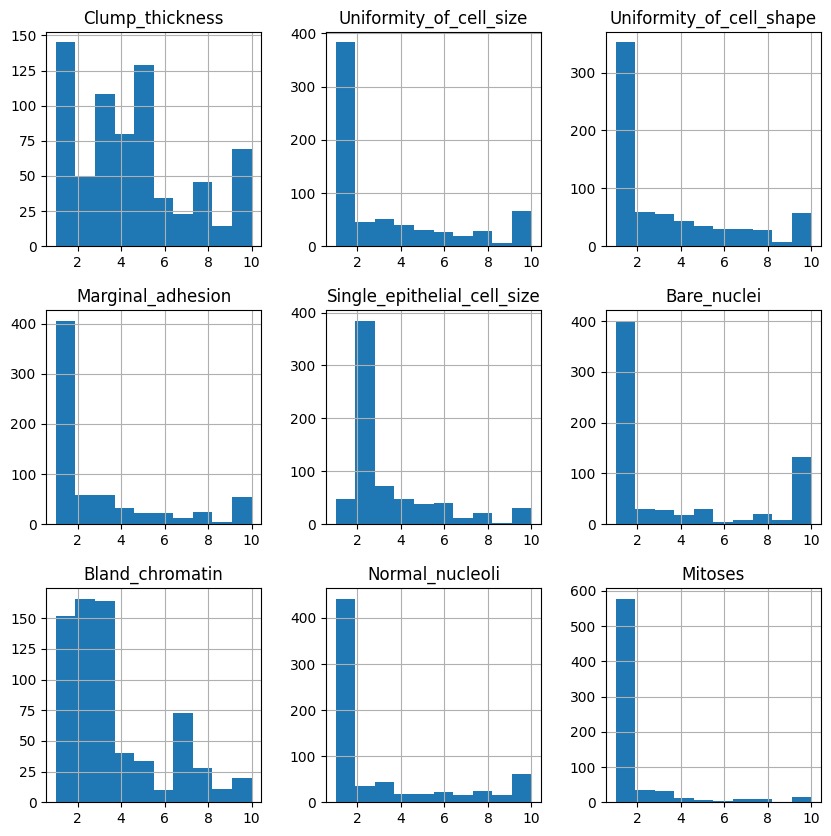

In [46]:
# Use histogram to see the distribution of the data
data.hist(figsize=(10, 10))
plt.show()

First thing that gets noticed when we look at the histograms is that columns Normal_nucleoli, Mitoses, Bare_nuclei, Single..., Marginel_adhesion, Unifromaty_of_cell_size, Unifromaty_of_cell_shape both has a single value that occurs so many times in dataset. Which is bad for our EDA as rows with similar features won't give us so much insight. Also high occurence of these values makes me question the precision of measurements.

(array([457., 241.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

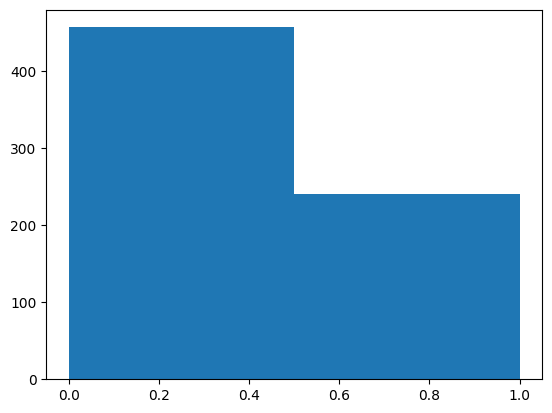

In [47]:
#histogram of is_malignant
plt.hist(data['Is_malignant'].astype(int),bins=2)

Looks like most of the cancer cells are not malignant but still the different is not huge which is good.

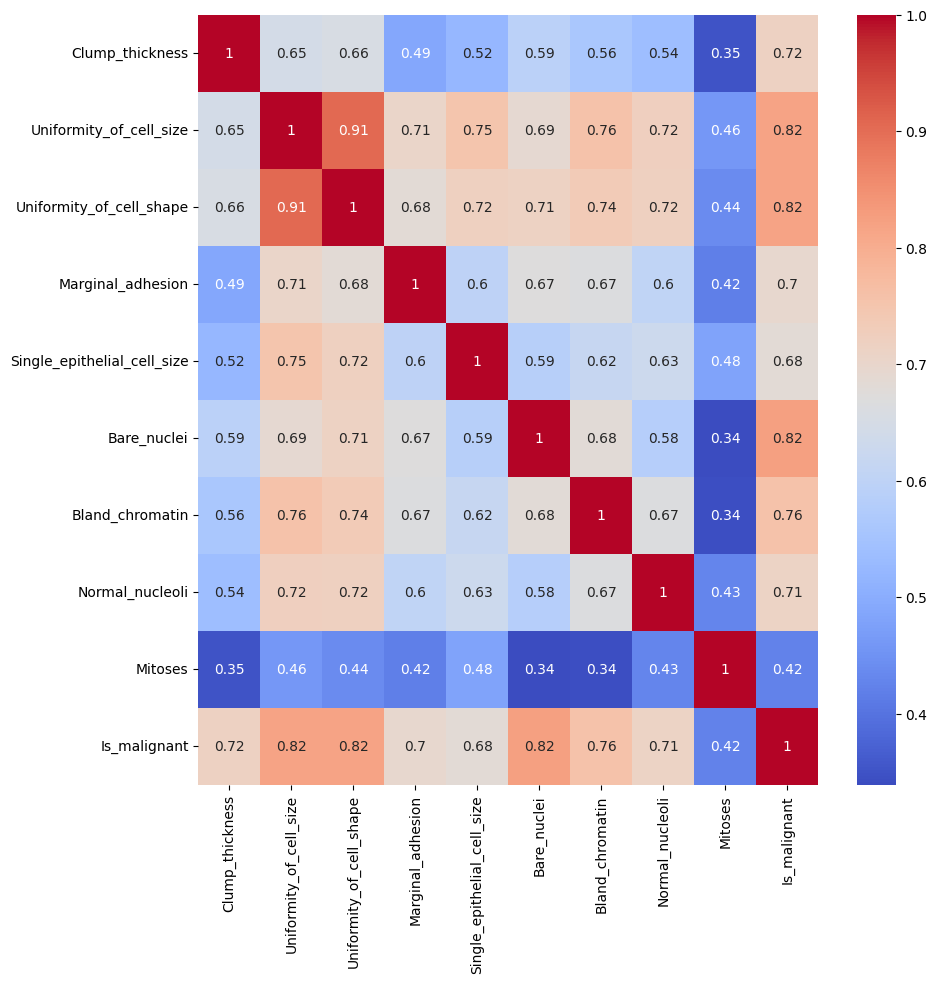

In [48]:
# correlation matrix on data
correlation = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()


Looking at the correlation matrix, we see almost every fature is highly correlated with cell malignancy which is really good. Almost every column having a positive correlation with malignancy except Mitoses. There even features that are highly correlated with each other like Uniformity of cell shape and size which have stunning correlation of 0.91.

It is given in data information that only feature Bare_nuclei has missing values so let's clean it.

In [49]:
null_values_column = data["Bare_nuclei"].isnull().sum()
print("Null values in Bare_nuclei column: ", null_values_column)

Null values in Bare_nuclei column:  16


Looking at the histogram of Bare nuclei we see that most of the values are either 1 or 10 and there are so few values in between. Giving the null values mean would not work due to this phenemoen so instead we will use mod.

In [50]:
# fill the missing values with the mod value
mod = data["Bare_nuclei"].mode()[0]
data["Bare_nuclei"].fillna(mod, inplace=True)

C:\Users\Salih\AppData\Local\Temp\ipykernel_10176\2100286709.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Bare_nuclei"].fillna(mod, inplace=True)


***Trying Different Models***

We won't be deleting outliers in this dataset since dataset is too small and features are given to us in categories instead of numbers.

In [51]:
from sklearn.model_selection import train_test_split
# import accuracy, precision, recall, ROC AUC score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# model runner
def modelRunner(model,train,test,willTrain=True):
    features = train.drop(['Is_malignant'], axis=1).columns
    # train the model
    if willTrain:
        model.fit(train[features], train['Is_malignant'])
    # make predictions
    predictions = model.predict(test[features])
    # calculate accuracy, precision, recall, and ROC AUC score
    accuracy = accuracy_score(test['Is_malignant'], predictions)
    precision = precision_score(test['Is_malignant'], predictions)
    recall = recall_score(test['Is_malignant'], predictions)
    roc_auc = roc_auc_score(test['Is_malignant'], predictions)
    # print the metrics
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("ROC AUC: ", roc_auc)
    # plt the ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(test['Is_malignant'], model.predict_proba(test[features])[:,1])
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()    
    return model


Accuracy:  0.9642857142857143
Precision:  0.9166666666666666
Recall:  1.0
ROC AUC:  0.9705882352941176


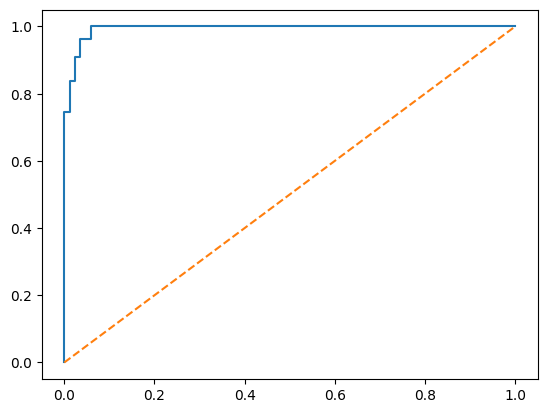

In [52]:
# train XGBoost model
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=0)
train, test = train_test_split(data, test_size=0.2, random_state=0)
model = modelRunner(model,train,test)

We reached a remarkable accuracy of 0.96 while having a recall of 1.0 and a relatively low precision of 0.91

***Logistic Regression***

Accuracy:  0.9714285714285714
Precision:  0.9636363636363636
Recall:  0.9636363636363636
ROC AUC:  0.9700534759358289


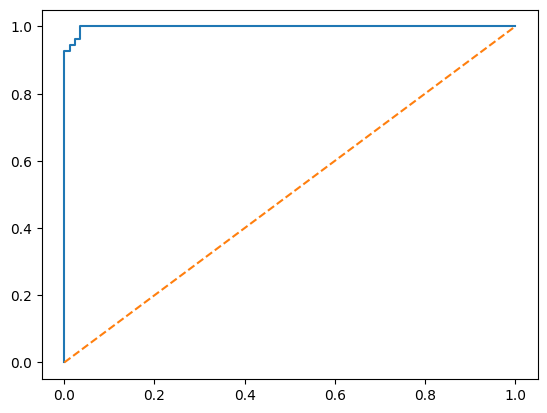

In [53]:
# import the logistic regression model
from sklearn.linear_model import LogisticRegression
# train the logistic regression model
model = LogisticRegression(random_state=0)
model = modelRunner(model,train,test)

If we compare Logistic regression to previos method XGBoost there was a drop in recall and Accuracy but Precision increased. Our metrics are more balanced now. Precision measures how close your results are to one another for this reason I think this result is better than the previous.

***Random Forest Classification***  

Accuracy:  0.9785714285714285
Precision:  0.9642857142857143
Recall:  0.9818181818181818
ROC AUC:  0.9791443850267381


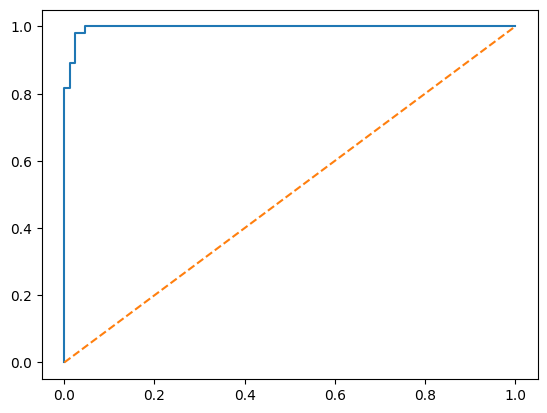

RandomForestClassifier(max_depth=7, n_estimators=200, random_state=0)

In [54]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier
# train the random forest model with grid search
from sklearn.model_selection import GridSearchCV
# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}
# define the model
model = RandomForestClassifier(random_state=0)
# define the grid search
grid_search = GridSearchCV(model, param_grid, cv=5)
features = train.drop(['Is_malignant'], axis=1).columns
# train the model
grid_search.fit(train[features], train['Is_malignant'])
modelRunner(grid_search.best_estimator_,train,test,False)


Using Random Forest Classification with grid search we reached higher scores in every score type than Logistic Regression.

***Support Vector Classification***

Accuracy:  0.9785714285714285
Precision:  0.9482758620689655
Recall:  1.0
ROC AUC:  0.9823529411764707


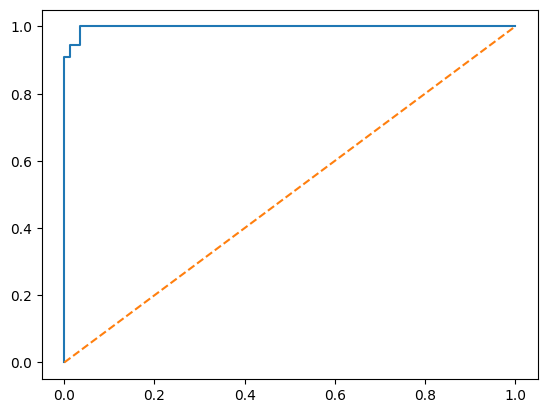

In [55]:
# train support vector machine model
from sklearn.svm import SVC
# define the model
model = SVC(probability=True, random_state=0)
# train the model
model = modelRunner(model,train,test)


We reached a similar score to XGBoost using support vector regression with high accuracy and recall but low precision. But all scores are little higher than XGBoost meaning that the best models we can compare are no longer XGBoost and Random Forest but rather SVC and Random Forest in between these two there is trade of between precision and recall.

***Neural Network Classificaiton*** 

Accuracy:  0.95
Precision:  0.9444444444444444
Recall:  0.9272727272727272
ROC AUC:  0.9459893048128343


C:\Users\Salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


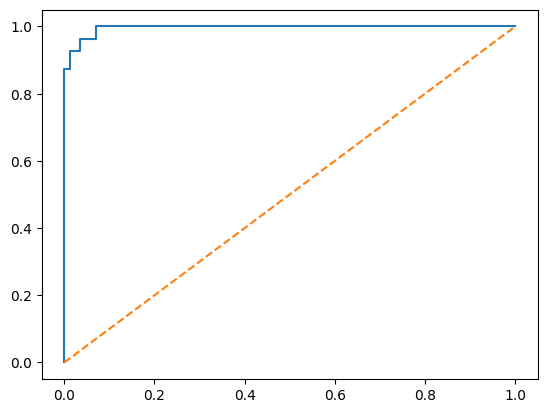

In [56]:
# train neural network model
from sklearn.neural_network import MLPClassifier
# define the model
model = MLPClassifier(random_state=0,activation='relu',hidden_layer_sizes=(100,50,15))
# train the model
model = modelRunner(model,train,test)

We reached lowest scores we have seen using neural network aproach

*** EXTRA: KNN Classification***

Accuracy:  0.9785714285714285
Precision:  0.9642857142857143
Recall:  0.9818181818181818
ROC AUC:  0.9791443850267381


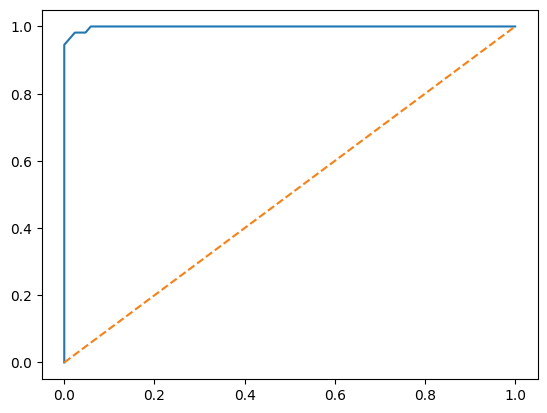

KNeighborsClassifier()

In [57]:
# train KNN model
from sklearn.neighbors import KNeighborsClassifier
# use grid search to find the best number of neighbors
param_grid = {
    'n_neighbors': [3, 5, 7, 9]
}
# define the model
model = KNeighborsClassifier()
# define the grid search
grid_search = GridSearchCV(model, param_grid, cv=5)
features = train.drop(['Is_malignant'], axis=1).columns
# train the model
grid_search.fit(train[features], train['Is_malignant'])
modelRunner(grid_search.best_estimator_,train,test,False)


We reached a very very similar scores compared to random forest classificaiton with our extra Model KNN which also trained lot faster.